# Trabalho Computacional 1 
- **Inteligência Computacional Aplicada**
- **Aluno**: Matheus Araujo dos Santos (matheus.santos@lapisco.ifce.edu.br)
- Programa de Pós-Graduacão em Engenharia Elétrica (PPGEE)
- Universidade Federal do Ceará, *Campus* do Pici, Fortaleza, Ceará, Brasil

## Questão 1.8 - Comitê de MLP's

Nessa implementação, foi usado o conceito de comitês de classificadores (chamados *ensembles*), que consiste em não usar só um classificador, mas um "comitê" deles, ou seja, cada um deles fazer predições distintas e independentes entre si, usando um subconjunto dos dados [1]. Cada modelo que compõe o comitê contribui para o resultado final de predição, e o uso de vários modelos faz com que ocorra uma redução do erro de generalização [2].

Foram utilizados no comitê 25 modelos do perceptron multicamadas (MLP) apresentado na questão 1.5. Para todos eles os pesos e os viéses foram inicializados de forma aleatória, com distribuição normal, taxa de aprendizado de 0.1, 500 épocas de treinamento, funções de ativação sigmóide (camada de entrada) e *softmax* (camada de saída), além do critério de parada com 15 épocas consecutivas de não convergência do modelo. O *loss* utilizado foi o erro quadrático médio.

Também foi utilizado o algoritmo de busca aleatória (*Random Search*) para escolha do número de neurônios na camada oculta. O intervalo de busca foi 300 a 500, com passo de 10. As demais configurações foram as mesmas dos modelos MLP (taxa de aprendizado, ativações e etc). 

Como estratégias para o comitê, foi utilizado o *bagging* para seleção do subconjunto de dados de treino para cada modelo no comitê, e o voto majoritário para a predição final.

### Sobre o dataset
A classificação foi feita para o *dataset* MNIST, de dígitos feitos à mão [3], que é composto por 60 mil imagens de treino e 10 mil imagens de teste. Todas elas são de dimensões 28x28 *pixels* e possuem suas respectivas classes (*labels*). O único pré-processamento utilizado foi a vetorização das imagens e a concatenação da matriz de imagens com um vetor de viés (*bias*), resultando em 785 atributos para a classificação. As *labels* também foram convertidas para o formato de vetor (*one hot*).

Os dados também foram transformados pelo uso do **PCA**, diminuindo a quantidade de atributos para 235 (redução de cerca de 70%) e acelerando bastante o processo de treinamento.

### Resultados
Dessa forma, após o treinamento, obtenção dos pesos e predição do conjunto de teste, obteve-se uma taxa de erro de **0.0831**, maior que o resultado obtido por LeCun *et al.* [3], que obteve **0.0039** nesse caso de estudo.

**Referências:**
1. HU, Yu Hen; PARK, Jong-Min; KNOBLOCK, Thomas. Committee pattern classifiers. In: **1997 IEEE International Conference on Acoustics, Speech, and Signal Processing**. IEEE, 1997. p. 3389-3392.
2. ZENOBI, Gabriele; CUNNINGHAM, Padraig. Using diversity in preparing ensembles of classifiers based on different feature subsets to minimize generalization error. In: **Machine Learning: ECML 2001: 12th European Conference on Machine Learning Freiburg, Germany, September 5–7, 2001 Proceedings 12**. Springer Berlin Heidelberg, 2001. p. 576-587.
3. Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." *Proceedings of the IEEE*, 86(11):2278-2324, November 1998.

2


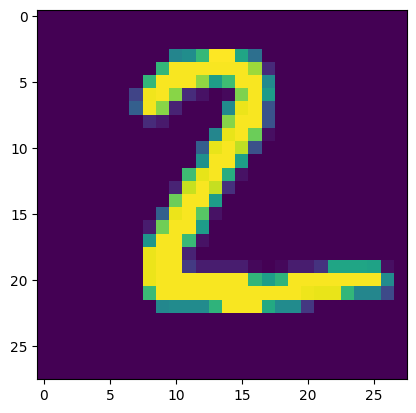

In [10]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

train_images_path = 'dataset/train-images.idx3-ubyte'
train_labels_path = 'dataset/train-labels.idx1-ubyte'
test_images_path = 'dataset/t10k-images.idx3-ubyte'
test_labels_path = 'dataset/t10k-labels.idx1-ubyte'

# Carregar o conjunto de treino para avaliação
arr_images_train = idx2numpy.convert_from_file(train_images_path)
arr_labels_train = idx2numpy.convert_from_file(train_labels_path).astype(int)

# Carregar o conjunto de teste para avaliação
arr_images_test = idx2numpy.convert_from_file(test_images_path)
arr_labels_test = idx2numpy.convert_from_file(test_labels_path).astype(int)

example = np.asarray(arr_images_test[1]).squeeze()
plt.imshow(example)

print(arr_labels_test[1])

In [11]:
print(arr_images_train.shape, arr_labels_train.shape)

(60000, 28, 28) (60000,)


In [12]:
# Transformar as imagens em vetores e normalizá-las
X_train = arr_images_train.reshape(arr_images_train.shape[0], -1)
X_test = arr_images_test.reshape(arr_images_test.shape[0], -1)

# Adicionar uma coluna de 1s para considerar o termo de bias (intercept) no modelo linear
X_train = np.column_stack((X_train, np.ones(X_train.shape[0])))
X_test = np.column_stack((X_test, np.ones(X_test.shape[0])))

# Colocar y em formato de vetor (one hot)
def one_hot_convert(vec):
    matrix = []
    for idx in vec:
      m = np.zeros((10, 1))
      m[idx] = 1
      matrix.append(m)
    return np.array(matrix)

y_train = one_hot_convert(arr_labels_train).reshape(arr_labels_train.shape[0], -1)
y_test = arr_labels_test.reshape(arr_labels_test.shape[0], -1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 785) (60000, 10)
(10000, 785) (10000, 1)


In [13]:
# Função para definir a matriz de transformação
def pca_train(X, tol):
    n = X.shape[0]

    # Normalização dos dados
    std = np.std(X, axis=0)
    X_norm = (X - np.mean(X, axis=0)) / np.where(std == 0, 1e-9, std) # Caso divisão por zero

    # Matriz de covariância
    Cx = (X_norm.T @ X_norm) / n
    
    eigenvalues, eigenvectors = np.linalg.eig(Cx)
    
    idxs = eigenvalues.argsort()[::-1] # Índices do maior para o menor
    eigenvalues = np.sort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idxs] # Montagem de autovetores

    var = np.cumsum(eigenvalues) / np.sum(eigenvalues) # variancia explicada

    num_components = np.sum(var <= tol) # Num. compon. principais

    Vq = eigenvectors[:, :num_components] # Matriz com q primeiros autovetores

    return Vq

# Função para aplicar a transformação nos dados
def pca_transform(Vq, X):
    # Normalização dos dados
    std = np.std(X, axis=0)
    X_norm = (X - np.mean(X, axis=0)) / np.where(std == 0, 1e-9, std) # Caso divisão por zero
    
    Z = X_norm @ Vq # Transformação
    
    return Z

Vq = pca_train(X_train, 0.9)
print(Vq.shape)

(785, 235)


In [14]:
X_train = pca_transform(Vq, X_train)
X_test = pca_transform(Vq, X_test)

print(X_train.shape, X_test.shape)

(60000, 235) (10000, 235)


In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV

def random_search(X, y):
    mlp = MLPClassifier(activation='logistic', learning_rate_init=0.01) # Mantendo configurações do MLP - l_rate, função de ativação sigmoid, etc

    params_search = {"hidden_layer_sizes": list(np.arange(300,500,10))}
    
    search = RandomizedSearchCV(mlp, param_distributions=params_search, n_jobs=-1, cv=3, verbose=5) # Busca do melhor numero de neuronios da camada
    search.fit(X, y)
    best = search.best_params_['hidden_layer_sizes']
    
    return best

# Funções de ativação para o neurônio
def activate_functions(type, matrix):
    if type == 'sigmoid':
        return 1 / (1 + np.exp(-matrix))
    elif type == 'softmax':
        exp_matrix = np.exp(matrix - np.max(matrix, axis=1, keepdims=True))
        return exp_matrix / np.sum(exp_matrix, axis=1, keepdims=True)   
    elif type == 'tanh':
        return np.tanh(matrix)

# Função de treino do MLP
def mlp_train(X, y, n_neurons_hlayer, epochs, l_rate, criteria):
    n_classes = y.shape[1]
    n_features = X.shape[1]

    w_input = np.random.randn(n_features, n_neurons_hlayer) * 0.1
    w_output = np.random.randn(n_neurons_hlayer, n_classes) * 0.1

    bias_input = np.random.randn(n_neurons_hlayer, 1) * 0.5
    bias_output = np.random.randn(n_classes, 1) * 0.5

    for epoch in range(epochs):
        
        # Forward
        Zin = (X @ w_input) + bias_input.T
        result_in = activate_functions('sigmoid', Zin)

        Zout = (result_in @ w_output) + bias_output.T
        result_out = activate_functions('softmax', Zout)

        # Backpropagation
        error_out = result_out - y
        grad_out = error_out / len(X)

        error_in = grad_out @ w_output.T
        grad_in = error_in * result_in * (1 - result_in)

        # Ajustar os pesos e os viéses
        w_input -= l_rate * np.dot(X.T, grad_in)
        w_output -= l_rate * np.dot(result_in.T, grad_out)

        bias_input -= l_rate * np.sum(grad_in, axis=0, keepdims=True).T
        bias_output -= l_rate * np.sum(grad_out, axis=0, keepdims=True).T

        if epoch == 0:
            loss = np.mean((y - result_out)**2)
            print('Initial Epoch: {}, loss: {}'.format(epoch, loss))
            best_loss = loss
            
        if epoch != 0 and epoch % 10 == 0:
            loss = np.mean((y - result_out)**2)
            
            if epoch % 100 == 0:
                print('Epoch: {}, loss: {}'.format(epoch, loss))

            if loss < best_loss:
                best_loss = loss
                wait = 0
            else: wait += 1

            if wait >= criteria:
                print('Final Epoch (loss stopped): {}, loss: {}'.format(epoch, loss))
                return w_input, w_output, bias_input, bias_output

    loss = np.mean((y - result_out)**2)
    print('Last Epoch: {}, loss: {}'.format(epoch+1, loss))
                                      
    return w_input, w_output, bias_input, bias_output

# Função de predição do MLP
def mlp_predict(X, w_in, w_out, bias_in, bias_out):
    # Forward
    Zin = (X @ w_in) + bias_in.T
    result_in = activate_functions('sigmoid', Zin)

    Zout = (result_in @ w_out) + bias_out.T
    result_out = activate_functions('softmax', Zout)

    # Converte as saídas para as classes preditas (0 a 9) usando a função argmax
    # A classe predita será o índice do valor máximo em cada linha
    classe = np.argmax(result_out, axis=1)
    print(classe.shape)

    return np.expand_dims(classe, axis=1)

In [16]:
# Função para fazer a sub-amostragem dos dados
def bagging_subsamples(X, y, percentage):
    n = len(X)
    sub_n = round(n * percentage)
    idxs = np.random.choice(n, sub_n, replace=True)
    X2 = X[idxs]
    y2 = y[idxs]
        
    return X2, y2

In [17]:
# Treinar o comitê de classificadores
n_committee = 25
committee_predictions = []

# Iterando cada classificador no committee
for i in range(n_committee):
    print('Classifier: {}/{}'.format(i+1,n_committee))
    X_train_sub, y_train_sub = bagging_subsamples(X_train, y_train, percentage=1.0)

    n_neurons = random_search(X_train_sub, y_train_sub)
    print("Neurons in hidden layer: ", n_neurons)
    
    w_input, w_output, bias_input, bias_output = mlp_train(X_train, y_train, n_neurons, epochs=500, l_rate=0.1, criteria=15)

    # Realizar a predição no conjunto de teste
    y_pred_test = mlp_predict(X_test, w_input, w_output, bias_input, bias_output)
    
    committee_predictions.append(y_pred_test)

print(committee_predictions)

Classifier: 1/25
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Neurons in hidden layer:  460
Initial Epoch: 0, loss: 0.10543300112448674
Epoch: 100, loss: 0.021893271014964993
[CV 1/3] END ............hidden_layer_sizes=430;, score=0.966 total time= 1.7min
[CV 2/3] END ............hidden_layer_sizes=410;, score=0.968 total time= 1.6min
[CV 2/3] END ............hidden_layer_sizes=300;, score=0.963 total time= 1.6min
[CV 2/3] END ............hidden_layer_sizes=480;, score=0.969 total time= 1.8min
[CV 3/3] END ............hidden_layer_sizes=460;, score=0.968 total time= 1.8min
[CV 2/3] END ............hidden_layer_sizes=390;, score=0.969 total time= 1.5min
[CV 3/3] END ............hidden_layer_sizes=380;, score=0.966 total time= 1.4min
[CV 2/3] END ............hidden_layer_sizes=430;, score=0.968 total time= 1.6min
[CV 2/3] END ............hidden_layer_sizes=450;, score=0.966 total time= 2.4min
[CV 3/3] END ............hidden_layer_sizes=300;, score=0.965 total time= 1.2min

In [18]:
# Voto majoritário
def majority_vote(row):
    return np.bincount(row).argmax() 

committee_arr = np.column_stack(committee_predictions)

final_y_pred_test = []
for row in committee_arr:
    # unique, counts = np.unique(row, return_counts=True)
    # print(dict(zip(unique, counts)))
    final_y_pred_test.append(majority_vote(row))

y_pred_test = np.expand_dims(np.array(final_y_pred_test), axis=1)
print(y_pred_test.shape)

(10000, 1)


In [19]:
# Avaliar o desempenho do classificador
error = (10000 - sum(y_pred_test == y_test)) / 10000 
print("Error rate: {}".format(error[0]))

Error rate: 0.0831
